<a href="https://colab.research.google.com/github/jvallalta/ia-medicina/blob/main/VAE_Imagenes_RX_Torax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders variacionales con imágenes de RX Tórax

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from google.colab import drive

In [ ]:
# Leemos el conjunto RSNA del drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Rutas
train = '/content/drive/MyDrive/rsna/stage_2_train_images'
test = '/content/drive/MyDrive/rsna/stage_2_test_images'
ruta = '/content/drive/MyDrive/rsna'

In [ ]:
# Cargamos el fichero con metadatos
imagenes = pd.read_csv(ruta+'/stage_2_detailed_class_info.csv')
imagenes.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
# Separamos imágenes pacientes sanos de imágenes de pacientes con anomalias
normales = imagenes[imagenes['class']=='Normal']
anormales = imagenes[imagenes['class']!='Normal']

In [ ]:
#Tamaños
print(normales.shape)
print(anormales.shape)

(8851, 2)
(21376, 2)


In [ ]:
#Definimos función lectura dicom
!pip install pydicom
import pydicom

     |████████████████████████████████| 1.9MB 17.9MB/s 


In [ ]:
#Función lectura imagen
def leer_dicom(imagen):
  ds = pydicom.dcmread(imagen)
    
  img = ds.pixel_array
  view = ds.ViewPosition
  sexo = ds.PatientSex
  edad = ds.PatientAge
  return img, view, sexo, edad

AP
F
34


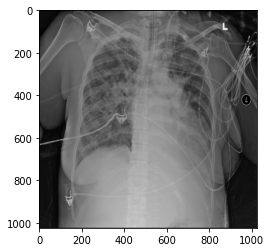

In [ ]:
# Probamos lectura de la imagen
prueba ='/content/drive/MyDrive/rsna/stage_2_train_images/02099738-7465-4786-b71c-de8cdac477c3.dcm'
imagen, vista, sexo, edad = leer_dicom(prueba)
plt.imshow(imagen, cmap='gray')
print(vista)
print(sexo)
print(edad)

In [ ]:
# Creamos dataframe con datos de pacientes normales
#pacientes_normales = pd.DataFrame(columns=('id_paciente', 'vista', 'sexo', 'edad'))
#for contador in range(len(normales)):
#  _, vista, sexo, edad = leer_dicom(train + '/' + normales.iloc[contador,0] + '.dcm')
#  pacientes_normales.loc[len(pacientes_normales)]=[normales.iloc[contador,0], vista, sexo, edad]

In [ ]:
#Leemos dataframe con los datos pacientes normales
pacientes_normales = pd.read_csv(ruta + '/pacientes_normales.csv')
pacientes_normales.head()

,Unnamed: 0,id_paciente,vista,sexo,edad
0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28
1,1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63
2,2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54
3,3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48
4,4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36


In [ ]:
pacientes_normales = pacientes_normales.drop(['Unnamed: 0'], axis=1)
pacientes_normales.head()

,id_paciente,vista,sexo,edad
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28
1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63
2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54
3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48
4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36


In [ ]:
pacientes_normales.to_csv(ruta + '/pacientes_normales.csv')

In [ ]:
# Nos quedamos con las imágenes con vista PA (Posteroanterior)
normales_PA = pacientes_normales[pacientes_normales['vista']=='PA']
normales_PA.shape

(7214, 4)

In [ ]:
normales_PA['ruta']=''
for contador in range(len(normales_PA)):
  normales_PA.iloc[contador,-1] = train + '/' + normales_PA.iloc[contador,0] + '.dcm'
print(normales_PA['ruta'].head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0    /content/drive/MyDrive/rsna/stage_2_train_imag...
1    /content/drive/MyDrive/rsna/stage_2_train_imag...
2    /content/drive/MyDrive/rsna/stage_2_train_imag...
3    /content/drive/MyDrive/rsna/stage_2_train_imag...
4    /content/drive/MyDrive/rsna/stage_2_train_imag...
Name: ruta, dtype: object


In [ ]:
normales_PA.head()

,id_paciente,vista,sexo,edad,ruta
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28,/content/drive/MyDrive/rsna/stage_2_train_imag...
1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63,/content/drive/MyDrive/rsna/stage_2_train_imag...
2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54,/content/drive/MyDrive/rsna/stage_2_train_imag...
3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48,/content/drive/MyDrive/rsna/stage_2_train_imag...
4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36,/content/drive/MyDrive/rsna/stage_2_train_imag...


In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Sun Feb 28 17:20:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
class RSNA(Dataset):
    """RSNA dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ruta_imagen = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.ruta_imagen)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.ruta_imagen.iloc[idx, 5]
        ds = pydicom.dcmread(img_name)
        image = ds.pixel_array
       
        

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
normales_PA.to_csv(ruta + '/normales_PA.csv')

In [ ]:
rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train)


In [ ]:
rsna_dataset.ruta_imagen

,Unnamed: 0,id_paciente,vista,sexo,edad,ruta
0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28,/content/drive/MyDrive/rsna/stage_2_train_imag...
1,1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63,/content/drive/MyDrive/rsna/stage_2_train_imag...
2,2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54,/content/drive/MyDrive/rsna/stage_2_train_imag...
3,3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48,/content/drive/MyDrive/rsna/stage_2_train_imag...
4,4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36,/content/drive/MyDrive/rsna/stage_2_train_imag...
...,...,...,...,...,...,...
7209,8845,c1c3ec5d-20ba-42f7-91f9-48032d97ffc9,PA,F,26,/content/drive/MyDrive/rsna/stage_2_train_imag...
7210,8846,c1ca4417-83a6-43a7-a9bf-7d9587e7f14f,PA,M,33,/content/drive/MyDrive/rsna/stage_2_train_imag...
7211,8847,c1cf3255-d734-4980-bfe0-967902ad7ed9,PA,F,27,/content/drive/MyDrive/rsna/stage_2_train_imag...
7212,8849,c1edf42b-5958-47ff-a1e7-4f23d99583ba,PA,F,46,/content/drive/MyDrive/rsna/stage_2_train_imag...


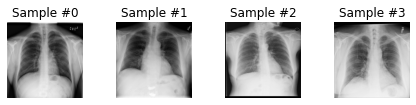

In [ ]:
rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train)

fig = plt.figure()

for i in range(len(rsna_dataset)):
    sample = rsna_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample, cmap='gray')
    
    if i == 3:
        plt.show()
        break

In [ ]:
image_size = 64
batch_size=32

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_size),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
rsna_dataset_test = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

testloader = torch.utils.data.DataLoader(rsna_dataset_test, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images)

def show_image(img):
    img = img / 2 + 0.5
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.show()

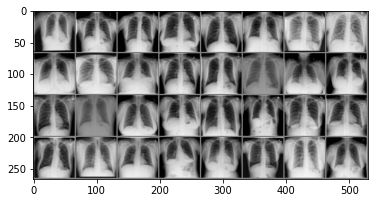

In [ ]:
trial = next(iter(trainloader))
images = trial
#print(labels)
show_images(images)

In [ ]:
trial.shape

torch.Size([32, 1, 64, 64])

# Modelo variacional base

In [ ]:

epochs = 10       # times to run the model on complete data
hidden_size = 1024       # hidden dimension
latent_size = 256         # latent vector dimension
lr = 5e-4                 # learning rate
factor_loss = 1
train_loss = []
num_imagenes = normales_PA.shape[0]

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)

In [ ]:
# Autoencoder convolucional variacional
class DCVAE(nn.Module):
    def __init__(self, image_channels=1, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
      super(DCVAE, self).__init__()

      self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 4, 2),
        nn.LeakyReLU(0.2),
        Flatten(),
    )
      self.encoder_mean = nn.Linear(hidden_size, latent_size)
      self.encoder_logvar = nn.Linear(hidden_size, latent_size)
      self.fc = nn.Linear(latent_size, hidden_size)
      self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(hidden_size, 128, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(128, 64, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(64, 32, 6, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(32, image_channels, 6, 2),
                                nn.Sigmoid()   
                              )
  
    def sample(self, log_var, mean):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mean)
  
    def forward(self, x):
      x = self.encoder(x)
      log_var = self.encoder_logvar(x)
      mean = self.encoder_mean(x)
      z = self.sample(log_var, mean)
      x = self.fc(z)
      x = self.decoder(x)

      return x, mean, log_var

In [ ]:
from torchsummary import summary
summary(vae, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]             544
         LeakyReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
         LeakyReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
         LeakyReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 256]         262,400
           Linear-11                  [-1, 256]         262,400
           Linear-12                 [-1, 1024]         263,168
        UnFlatten-13           [-1, 1024, 1, 1]               0
  ConvTranspose2d-14            [-1, 12

## Autoencoder variacional mejorado

In [ ]:
image_size = 128
batch_size=32

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_size),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
rsna_dataset_test = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

testloader = torch.utils.data.DataLoader(rsna_dataset_test, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

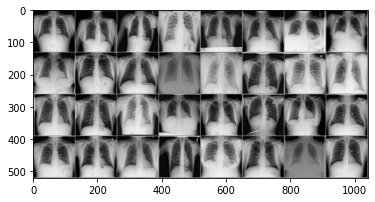

In [ ]:
trial = next(iter(trainloader))
images = trial
#print(labels)
show_images(images)

In [ ]:
epochs = 10        # times to run the model on complete data
hidden_size = 3136       # hidden dimension
latent_size = 256         # latent vector dimension
lr = 5e-4                 # learning rate
factor_loss = 1
train_loss = []
num_imagenes = normales_PA.shape[0]

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        #print(input.shape)
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=3136):
        print(input.shape)
        return input.view(input.size(0), 64, 7, 7)

In [ ]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [ ]:
image_size

128

In [ ]:
# Autoencoder convolucional mejorado
class DCVAE2(nn.Module):
    def __init__(self, image_channels=1, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
      super(DCVAE2, self).__init__()

      self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 3, 2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(32, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        Flatten(),
    )
      self.encoder_mean = nn.Linear(hidden_size, latent_size)
      self.encoder_logvar = nn.Linear(hidden_size, latent_size)
      self.fc = nn.Linear(latent_size, hidden_size)
      self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(64, 64, 3, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 64, 3, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 32, 3, 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(32, image_channels, 3, 2),
                                nn.Sigmoid()   
                              )
  
    def sample(self, log_var, mean):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mean)
  
    def forward(self, x):
      x = self.encoder(x)
      log_var = self.encoder_logvar(x)
      mean = self.encoder_mean(x)
      z = self.sample(log_var, mean)
      x = self.fc(z)
      print(x.shape)
      x = self.decoder(x)
      
      return x, mean, log_var

In [ ]:
vae2 = DCVAE2().to(device)
# vae = VAE().to(device)
optimizer = optim.Adam(vae2.parameters(), lr=lr)

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(vae2, input_size=(1, 128, 128))

torch.Size([2, 3136])
torch.Size([2, 3136])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]             320
       BatchNorm2d-2           [-1, 32, 63, 63]              64
         LeakyReLU-3           [-1, 32, 63, 63]               0
         Dropout2d-4           [-1, 32, 63, 63]               0
            Conv2d-5           [-1, 64, 31, 31]          18,496
       BatchNorm2d-6           [-1, 64, 31, 31]             128
         LeakyReLU-7           [-1, 64, 31, 31]               0
         Dropout2d-8           [-1, 64, 31, 31]               0
            Conv2d-9           [-1, 64, 15, 15]          36,928
      BatchNorm2d-10           [-1, 64, 15, 15]             128
        LeakyReLU-11           [-1, 64, 15, 15]               0
        Dropout2d-12           [-1, 64, 15, 15]               0
           Conv2d-13             [-1, 64, 7, 7]          36

In [ ]:
vae2.train()

for epoch in range(epochs):
  for i, images in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae2(images)
    CE = RMSELoss(reconstructed_image, images)
    #CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = factor_loss*CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

torch.Size([32, 3136])
torch.Size([32, 3136])


RuntimeError: ignored

In [ ]:
# Cargamos modelo entrenado
vae.load_state_dict(torch.load(ruta + '/vae1.pth'))

<All keys matched successfully>

In [ ]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [ ]:
for i, _ in enumerate(trainloader):
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


In [ ]:
vae.train()

for epoch in range(epochs):
  for i, images in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae(images)
    CE = RMSELoss(reconstructed_image, images)
    #CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = factor_loss*CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

Loss:
3.1682474613189697
Loss:
0.018675798550248146
Loss:
0.016317270696163177
Loss:
0.016123782843351364
Loss:
0.016911238431930542
Loss:
0.017869163304567337
Loss:
0.0160692036151886
Loss:
0.01450333371758461
Loss:
0.015565946698188782
Loss:
0.01449095644056797
Loss:
0.014567446894943714
Loss:
0.015370611101388931
Loss:
0.014674604870378971
Loss:
0.015699099749326706
Loss:
0.015168693847954273
Loss:
0.015153593383729458
Loss:
0.014313706196844578
Loss:
0.015303166583180428
Loss:
0.014374400489032269
Loss:
0.015315469354391098
Loss:
0.014510966837406158
Loss:
0.015741070732474327
Loss:
0.01440522912889719
Loss:
0.014997638761997223
Loss:
0.0141221322119236
Loss:
0.014640052802860737
Loss:
0.014600702561438084
Loss:
0.014368333853781223
Loss:
0.014442180283367634
Loss:
0.014756673946976662


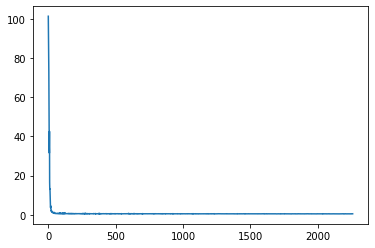

In [ ]:
plt.plot(train_loss)
plt.show()

## Generación de una imagen sintética

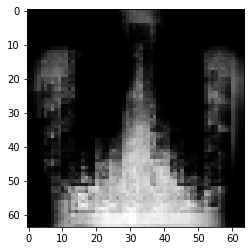

In [ ]:
start = torch.randn(1,latent_size)
with torch.no_grad():
  z = torch.FloatTensor(start)
  z = z.reshape((-1, latent_size))
  z = z.to(device)
  z = vae.fc(z)
  generated_images = vae.decoder(z)
  generated_images = generated_images.view(-1, image_size, image_size)
  img = generated_images[0].cpu()
  img = img / 2 + 0.5
  plt.imshow(img, cmap='gray')

## Evaluamos la reconstrucción de imágenes

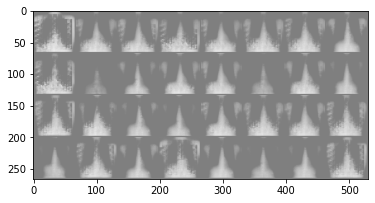

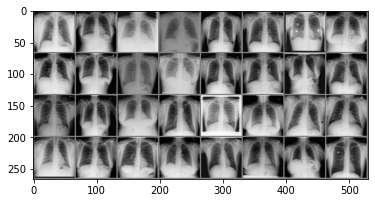

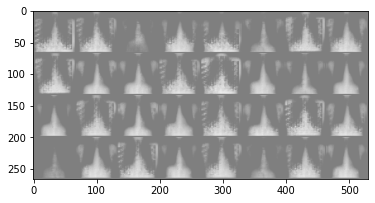

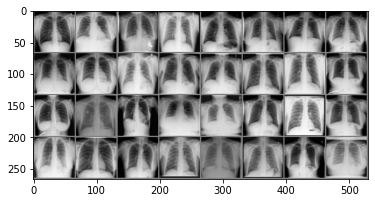

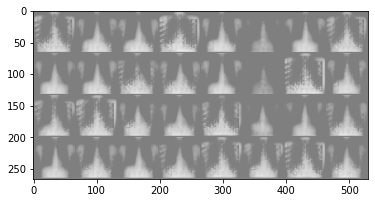

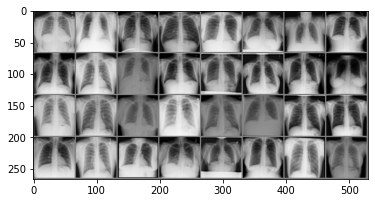

In [ ]:
vae.eval()
vectors = []
with torch.no_grad():
  for i, images in enumerate(testloader):
    images = images.to(device)
    reconstructed_image, mean, log_var = vae(images)
    reconstructed_image = reconstructed_image.view(-1, 1, image_size, image_size)
    temp = list(mean.tolist())
    for x in temp:
      vectors.append(x)
    if(i%100 == 0):
      show_images(reconstructed_image.cpu())
      #img_name = images_dir + "evaluation/DCVAE/" + str(i).zfill(3)
      # img_name = images_dir + "evaluation/VAE/" + str(i).zfill(3)
      #plt.savefig(img_name)
      plt.show()
      show_images(images.cpu())
      plt.show()

In [ ]:
torch.save(vae.state_dict(), ruta + '/vae_rmse_k1.pth')

In [ ]:
torch.randn(1,32)

tensor([[ 0.8084, -1.0964, -1.6488,  1.0668,  1.7259,  1.6095, -1.0049, -0.9723,
          0.6944, -0.8953, -0.4756, -1.1805, -2.0021,  0.7330,  0.9015, -1.3063,
         -0.0941, -2.4286, -0.3798, -1.0591,  0.1618,  0.1782,  0.7836,  0.3604,
         -1.1584,  0.3359,  0.5236, -0.4386, -0.9104, -2.1541, -0.0471,  0.3206]])

In [ ]:
vae.eval()
start = np.array([-1.8611,  0.3629, -0.1625,  0.6801,  1.2033,  1.0312,  0.5436,  1.3066,
         0.2905,  0.1377,  0.5122, -0.1663,  2.3431, -0.0896, -0.5873, -1.4804,
         0.8141, -1.2197,  0.0484,  0.6414, -0.8172, -0.9543, -0.8818, -1.1465,
         0.2720,  1.1792,  1.8410, -0.4715,  1.4380,  0.5139,  1.2099, -0.5012])
middle = np.array([-0.4763, -0.4644, -0.3850,  0.6598,  0.9110,  0.4451,  0.4617, -0.0526,
         0.2808,  0.6080,  0.5532, -1.5506, -0.5199,  0.1359,  0.0373,  0.4284,
        -0.4134, -1.7078, -0.0309, -1.0195, -0.3151, -0.5569,  0.2832, -0.9132,
        -1.1339, -1.3196,  2.1297,  0.8122,  0.6849, -0.6710, -0.3507, -0.9001])
end = np.array([-1.6239,  0.2496, -1.0690, -0.8745,  0.4133,  2.2452, -0.2385, -0.6532,
         0.3818, -0.9425,  0.9404,  1.3901, -0.3327, -0.3719, -0.0365,  0.3240,
         0.4928, -0.4988, -1.2228, -0.1638,  0.6093, -0.5264, -1.6963, -0.3718,
         2.1971,  0.2166, -0.0821, -0.1722, -0.1896, -1.6610, -0.1497,  1.0655])
#points = 50
#linfit = interpolate.interp1d([1, points/2, points], np.vstack([start, middle, end]), axis=0)
with torch.no_grad():
  for i in range(3):
    z = linfit(i)
    z = torch.FloatTensor(z)
    print(z.shape)
    z = z.reshape((-1, 32))
    z = z.to(device)
    z = vae.fc(z)
    generated_images = vae.decoder(z)
    generated_images = generated_images.view(-1, 64, 64)
    img = generated_images[0].cpu()
    plt.imshow(img)
    img_name = images_dir + 'interpolate/' + str(i).zfill(3)
    plt.savefig(img_name)
    plt.show()

NameError: ignored

torch.Size([1, 128, 128])
(128, 128)


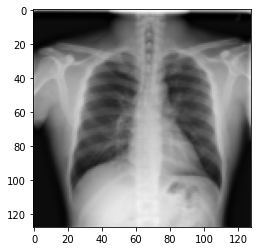

In [ ]:
# Grab a sample image
import random

idx = random.randint(0,10)
tensor = rsna_dataset[idx]
print(tensor.shape)
image = np.squeeze(tensor.numpy())
print(image.shape)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
#image = image.transpose((1, 2, 0))
plt.imshow(image, cmap='gray')

In [ ]:
batch_size = 16          # number of inputs in each batch
epochs = 2               # times to run the model on complete data
image_size = 128
hidden_size = 1024        # hidden dimension
latent_size = 32          # latent vector dimension
lr = 1e-3                 # learning rate
train_loss = []

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3
        )
        self.enc2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3
        )
        self.enc3 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3
        )
        self.enc4 = nn.Conv2d(
            in_channels=1, out_channels=8, kernel_size=3
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64, kernel_size=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=8, out_channels=1, kernel_size=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=8, out_channels=1, kernel_size=3
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=8, out_channels=1, kernel_size=3
        )
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        return x

model = Autoencoder().to(device)
print(model)


Autoencoder(
  (enc1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (enc3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (enc4): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (dec3): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (dec4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
kernel_size = 3 # (3, 3) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

In [ ]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var


In [ ]:
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 2
batch_size = 16
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [ ]:
from tqdm import tqdm
import torch 
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

In [ ]:
len(rsna_dataset)

7214

In [ ]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, rsna_dataset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, trainloader, rsna_dataset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1 of 2


  0%|          | 0/450 [00:05<?, ?it/s]


RuntimeError: ignored

In [ ]:
#Loss function
criterion = nn.MSELoss() # BinaryCrossEntropy

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS=2
train_loss = []
model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in trainloader:
        img = data # no need for the labels
        print(img.shape)
        img = img.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*img.size(0)
        
    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))

torch.Size([16, 1, 128, 128])


RuntimeError: ignored

In [ ]:
trainloader

In [ ]:
dataiter = iter(trainloader)
dataiter.next().shape

torch.Size([32, 1, 128, 128])

In [ ]:
z = torch.randn(1, 20).to(device)
# run only the decoder
reconstructed_img = model.dec(z)
#reconstructed_img = reconstructed_img.cpu().numpy()

#output = model(images)
#images = images.cpu().numpy()
img = reconstructed_img.view(224, 224).data
img = img.cpu().detach().numpy()
#img = reconstructed_img .view(batch_size, 3, 32, 32)
#img = img.cpu().detach().numpy()

#output = output.view(batch_size, 3, 32, 32)
#output = output.cpu().detach().numpy()
#img = reconstructed_img.view(224, 224).data
print(z.shape)
print(img.shape)
plt.imshow(img,cmap='gray')

In [ ]:
# Fixed input for debugging
fixed_x, _ = next(iter(trainloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

ValueError: ignored

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


In [ ]:

model = VAE(image_channels=image_channels).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:

epochs = 2

In [ ]:
for epoch in range(epochs):
    for idx, images in enumerate(trainloader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        print(to_print)

# notify to android when finished training
notify(to_print, priority=1)

torch.save(vae.state_dict(), 'vae.torch')

RuntimeError: ignored